# Segmentando clientes

En esta notebook se verá una forma sobre como segmentar a los clientes, cuando cuenta con una gran cantidad de estos sobre una base de datos de una gran (?) cantidad de dimensiones.

Empezaremos cargando el entorno e instalando los requerimentos necesarios.

In [1]:
# %pip install umap-learn

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns

from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.ensemble import  RandomForestClassifier
from sklearn.impute import SimpleImputer

2025-09-21 17:40:39.350813: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-21 17:40:39.359449: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758487239.368011   15548 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758487239.370813   15548 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1758487239.378723   15548 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [4]:
base_path = '/home/augusto/Desktop/dmeyf2025/'
dataset_path = base_path + 'Data/'
modelos_path = base_path + 'models/'
db_path = base_path + 'db/'
dataset_file = 'competencia_miranda.csv'

In [5]:
df_train = pd.read_csv(dataset_path + dataset_file)

Solo segmentaremos a los clientes de abril, dado que necesitaremos variables en algún momento agregar variables históricas para entender su comportamiento previo a la **baja**

In [6]:
df_train = df_train[df_train['foto_mes']==202104]

A su vez, nos concentraremos en el fenómeno de la **baja**. No importa si es en un mes o si es en dos.

In [7]:
Xtrain = df_train
ytrain = Xtrain["clase_ternaria"].map(lambda x: 0 if x == "CONTINUA" else 1)
Xtrain = Xtrain.drop("clase_ternaria", axis=1)

del(df_train)

Lo primero que necesitamos es saber cuando un cliente es parecido a otro. Todos los clientes que son parecidos los juntaremos en un **segmento** y sobre esos segmentos haremos perfilados o profiles para entender que los caracteriza.

Saber cuando un cliente es parecido a otro no es algo tan simple en un problema de alta dimensionalidad, lo que se suele llamar **curse of dimensionality**. Las cosas no son lo mismo más allá de nuestras 3 escasas dimensiones. Para muestra, un botón: https://www.youtube.com/watch?v=mceaM2_zQd8

Por esto, es conveniente usar herramientas que nos ayuden a no tener que hacer distancias euclídeas.

Empecemos con una ayuda con nos dan nuestros amigos, los **rf** con una original matriz de distancias (https://en.wikipedia.org/wiki/Distance_matrix)

La **Random Forest Distance** es una matriz derivada del algoritmo Random Forest,

+ Se utiliza para medir la similitud entre pares de puntos de datos. Esta métrica se basa en la idea de cuántas veces dos puntos de datos terminan en la misma hoja de un árbol en un **rf**, entre los múltiples árboles que se generan.

+ Cómo se Calcula?

 1. Se entrena un **rf**.
 2. Para cada par de clientes $c_i$ y $c_j$, se observa cuántas veces caen en la misma hoja a través de todos los árboles del bosque. Luego se agrega en la posición $i$, $j$ de una matriz el número de veces que coincidieron esos dos clientes en un nodo terminal.
 3. Se calcula la matriz de distancia como **1 - proporción de veces que caen en la misma hoja**. Ejemplo: Si caen en la misma hoja el 90% de las veces, su distancia será 0.1. Si nunca caen en la misma hoja, la distancia es 1.

Veamoslo aplicado en nuestro caso

Para trabajar con este algoritmo no vamos a trabajar con todos los datos. Usted decida con cuantos trabajar. En este caso, tomaremos todos los **baja** y unos 2000 **continua**, ya que queremos como interactuan los segmentos de clientes que se van con los que se quedan.


In [8]:
np.random.seed(17)
continua_sample = ytrain[ytrain == 0].sample(2000).index
bajas_1_2 = ytrain[ytrain == 1].index
rf_index = continua_sample.union(bajas_1_2)

Xtrain_rf = Xtrain.loc[rf_index]
ytrain_rf = ytrain.loc[rf_index]

Entrenamos un simple **rf**, despliegue sus herramientas aprendidas para contar con un buen modelo


In [9]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
Xtrain_rf_imp = imp_mean.fit_transform(Xtrain_rf)

model = RandomForestClassifier(n_estimators=100, max_features=20, min_samples_leaf=400, random_state=17 )
model.fit(Xtrain_rf_imp, ytrain_rf)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,400
,min_weight_fraction_leaf,0.0
,max_features,20
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Armamos (copiamos de internet) una función que nos calcule la matriz de distancias

In [10]:
def distanceMatrix(model, X):

    terminals = model.apply(X)
    nTrees = terminals.shape[1]

    a = terminals[:,0]
    proxMat = 1*np.equal.outer(a, a)

    for i in range(1, nTrees):
        a = terminals[:,i]
        proxMat += 1*np.equal.outer(a, a)

    proxMat = proxMat / nTrees

    return proxMat.max() - proxMat

md = distanceMatrix(model, Xtrain_rf_imp)

Veamos como se ve. Recuerde que significa que un número esté cerca de 0 o que esté cerca de 1.

In [11]:
md

array([[0.  , 0.81, 0.62, ..., 0.9 , 0.72, 0.63],
       [0.81, 0.  , 0.96, ..., 0.62, 0.97, 0.71],
       [0.62, 0.96, 0.  , ..., 0.98, 0.23, 0.82],
       ...,
       [0.9 , 0.62, 0.98, ..., 0.  , 0.94, 0.67],
       [0.72, 0.97, 0.23, ..., 0.94, 0.  , 0.77],
       [0.63, 0.71, 0.82, ..., 0.67, 0.77, 0.  ]])

Para poder visualizar la matriz, utilizaremos un embedding. Los *embeddings* son representaciones vectoriales de datos en un espacio de menor dimensión

Podría utilizar un **PCA** con ese fin, pero en los últimos años hay mejores algoritmos como **t-sne** o **umap**.

UMAP (Uniform Manifold Approximation and Projection) es una técnica avanzada para la reducción de dimensionalidad y visualización de datos en espacios de menor dimensión, que busca mantener al máximo la estructura de los datos en alta dimensión.

1. **Preservación de la Estructura Global y Local**:
   - Intenta preservar tanto la estructura local (relaciones cercanas) como la global (estructura general) de los datos al proyectarlos en un espacio de menor dimensión.

2. **Basado en Manifold Learning**:
   - UMAP asume que los datos de alta dimensión se encuentran en un espacio de menor dimensión (un "manifold") y busca proyectar esos datos de manera que se mantenga esa estructura subyacente.

3. **Velocidad y Escalabilidad**:
   - UMAP es más rápido y escalable en comparación con técnicas similares como t-SNE, especialmente en conjuntos de datos grandes.

4. **Control sobre la Estructura**:
   - UMAP permite al usuario ajustar parámetros que controlan la preservación de la estructura local y global, como el número de vecinos cercanos (n_neighbors) y la distancia mínima entre puntos (min_dist).

Una característica adicional, es que cuenta con la posibilidad de recibir de entrada una matriz de distancia.

Veamos los datos por primera vez:

/home/augusto/.venv/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/augusto/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


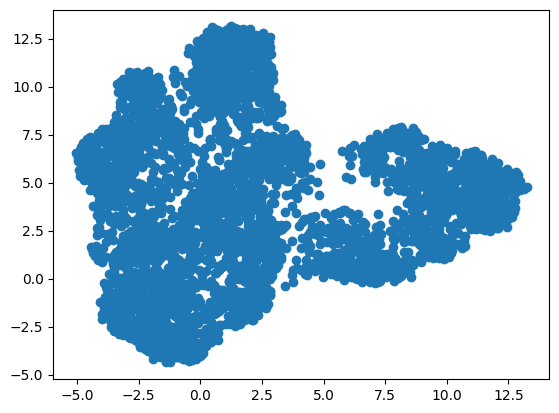

In [12]:
embedding_rf = UMAP(
  n_components=2,
  n_neighbors=20,
  min_dist=0.77,
  learning_rate=0.05,
  metric="precomputed",
  random_state=17,
).fit_transform(md)

plt.scatter(embedding_rf[:,0], embedding_rf[:,1])

Agreguemos la dimensión de la probabilidad de salida, para ver donde cree el modelo que se encuentran los **bajas**.

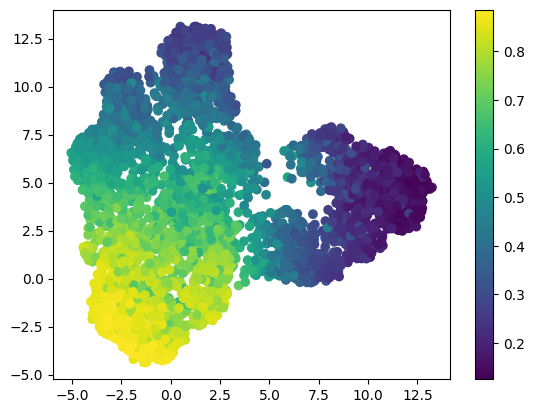

In [13]:
class_index = np.where(model.classes_ == 1)[0]
prob_baja = model.predict_proba(Xtrain_rf_imp)[:,class_index]

plt.scatter(embedding_rf[:,0], embedding_rf[:,1], c=prob_baja)
plt.colorbar()
plt.show()

Calculando métricas para diferentes valores de k...
  k = 2, WCSS = 89080.75, Silhouette Score = 0.4520
  k = 3, WCSS = 41577.91, Silhouette Score = 0.5110
  k = 4, WCSS = 32218.79, Silhouette Score = 0.4524
  k = 5, WCSS = 24072.21, Silhouette Score = 0.4655
  k = 6, WCSS = 19481.34, Silhouette Score = 0.4606
  k = 7, WCSS = 16453.29, Silhouette Score = 0.4377
  k = 8, WCSS = 13641.69, Silhouette Score = 0.4468
  k = 9, WCSS = 11874.53, Silhouette Score = 0.4434
  k = 10, WCSS = 10461.10, Silhouette Score = 0.4318
  k = 11, WCSS = 9304.17, Silhouette Score = 0.4259
  k = 12, WCSS = 8434.86, Silhouette Score = 0.4250
  k = 13, WCSS = 7758.80, Silhouette Score = 0.4134
  k = 14, WCSS = 7133.11, Silhouette Score = 0.4032
  k = 15, WCSS = 6752.52, Silhouette Score = 0.3965
  k = 16, WCSS = 6234.51, Silhouette Score = 0.3995
  k = 17, WCSS = 5918.06, Silhouette Score = 0.3963
  k = 18, WCSS = 5584.59, Silhouette Score = 0.3917
  k = 19, WCSS = 5314.01, Silhouette Score = 0.3827
  k = 20, W

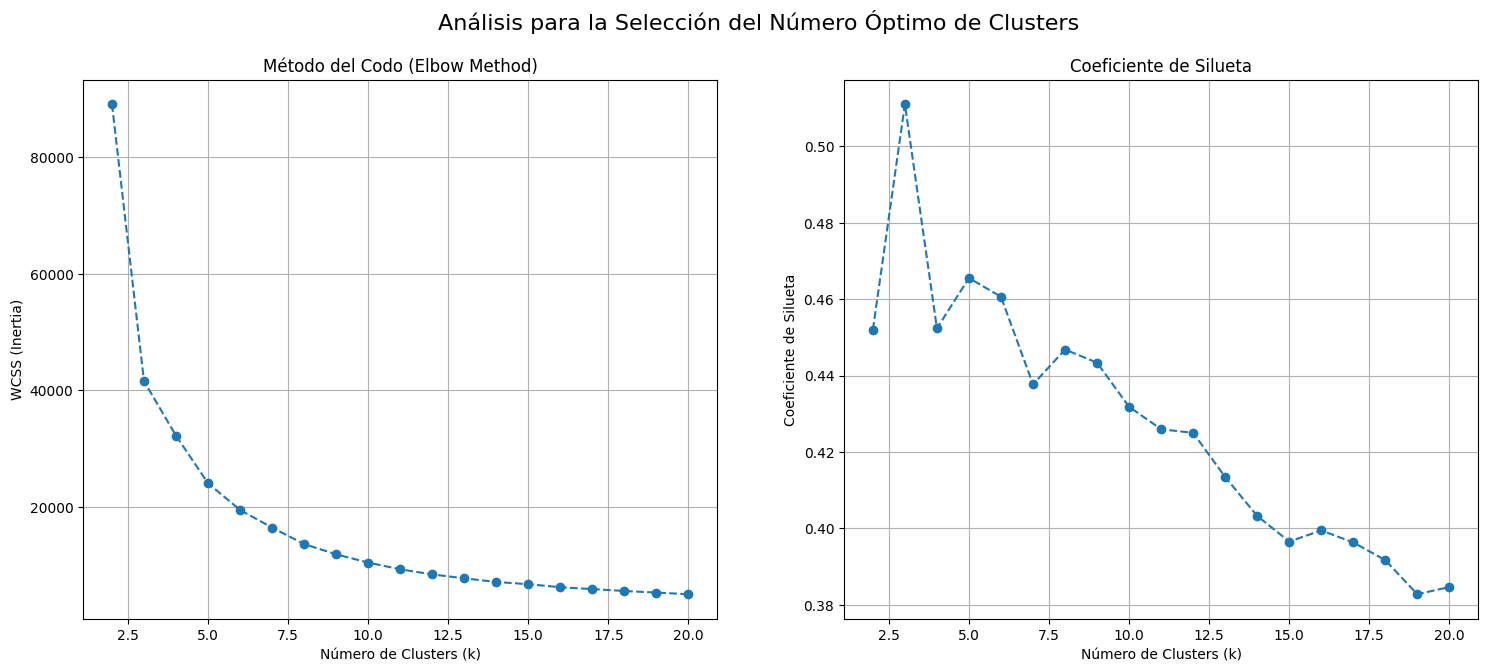

In [21]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# --- TU ACCIÓN: Define el rango de clusters a probar ---
# Un rango de 2 a 20 suele ser un buen punto de partida.
k_range = range(2, 21)

wcss = []  # Suma de los cuadrados dentro de los clusters (para el codo)
silhouette_scores = []  # Puntuaciones de silueta

print("Calculando métricas para diferentes valores de k...")
for k in k_range:
    # Entrenar el modelo KMeans para el valor actual de k
    kmeans = KMeans(n_clusters=k, random_state=17, n_init=10)
    kmeans.fit(embedding_rf)
    
    # 1. Para el Método del Codo, guardamos la inercia
    wcss.append(kmeans.inertia_)
    
    # 2. Para el Coeficiente de Silueta, calculamos y guardamos el score
    score = silhouette_score(embedding_rf, kmeans.labels_)
    silhouette_scores.append(score)
    print(f"  k = {k}, WCSS = {kmeans.inertia_:.2f}, Silhouette Score = {score:.4f}")

print("\nCálculos finalizados. Generando gráficos...")

# Crear una figura con dos subplots (uno para cada método)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# --- Gráfico 1: Método del Codo ---
ax1.plot(k_range, wcss, marker='o', linestyle='--')
ax1.set_xlabel('Número de Clusters (k)')
ax1.set_ylabel('WCSS (Inertia)')
ax1.set_title('Método del Codo (Elbow Method)')
ax1.grid(True)

# --- Gráfico 2: Coeficiente de Silueta ---
ax2.plot(k_range, silhouette_scores, marker='o', linestyle='--')
ax2.set_xlabel('Número de Clusters (k)')
ax2.set_ylabel('Coeficiente de Silueta')
ax2.set_title('Coeficiente de Silueta')
ax2.grid(True)

plt.suptitle('Análisis para la Selección del Número Óptimo de Clusters', fontsize=16)
plt.show()

Vamos a partir de este embedding para segmentar a los clientes. Puede utilizar cualquier técnica, los datos ya son simples para cualquier algoritmo. Utilizaremos uno bastante estandar

--- Calculando clusters para k = 5 ---


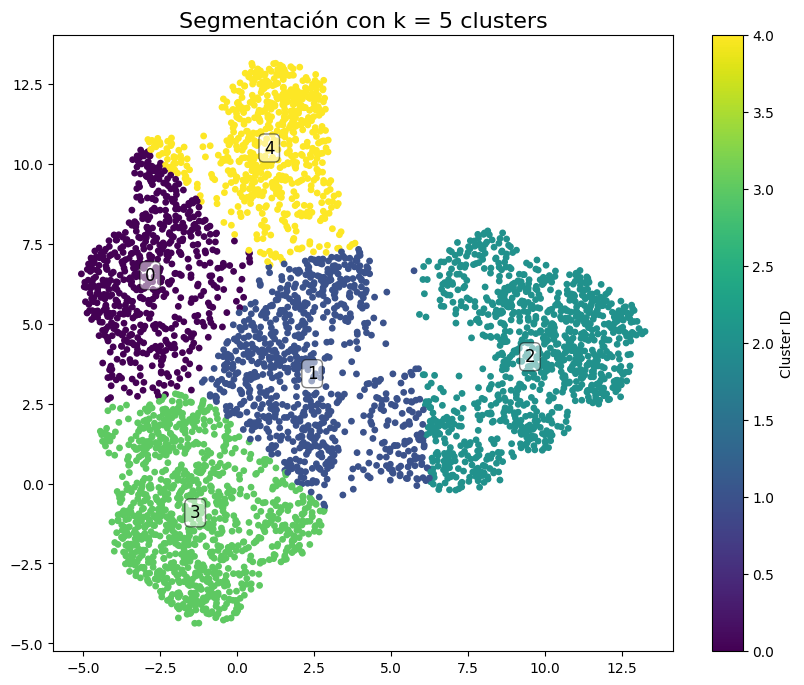

Number of cases per class and average churn probability per cluster:
original_class    0    1  average_prob_baja
cluster                                    
0               273  364           0.521972
1               268  534           0.598257
2               954   61           0.227609
3                60  950           0.816685
4               445  176           0.344518
--- Calculando clusters para k = 6 ---


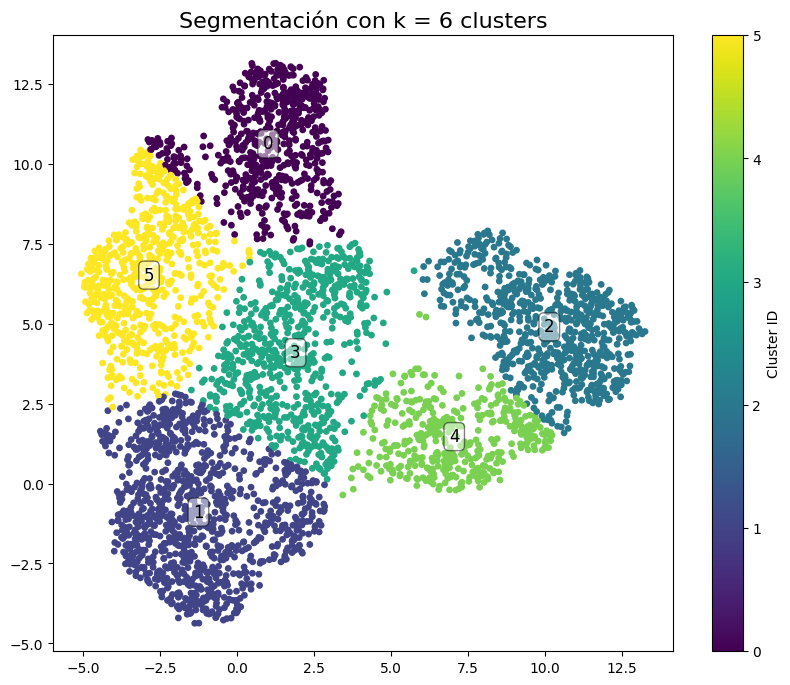

Number of cases per class and average churn probability per cluster:
original_class    0    1  average_prob_baja
cluster                                    
0               436  161           0.339064
1                62  976           0.815697
2               693   44           0.206714
3               198  487           0.612204
4               340   59           0.334283
5               271  358           0.521332
--- Calculando clusters para k = 7 ---


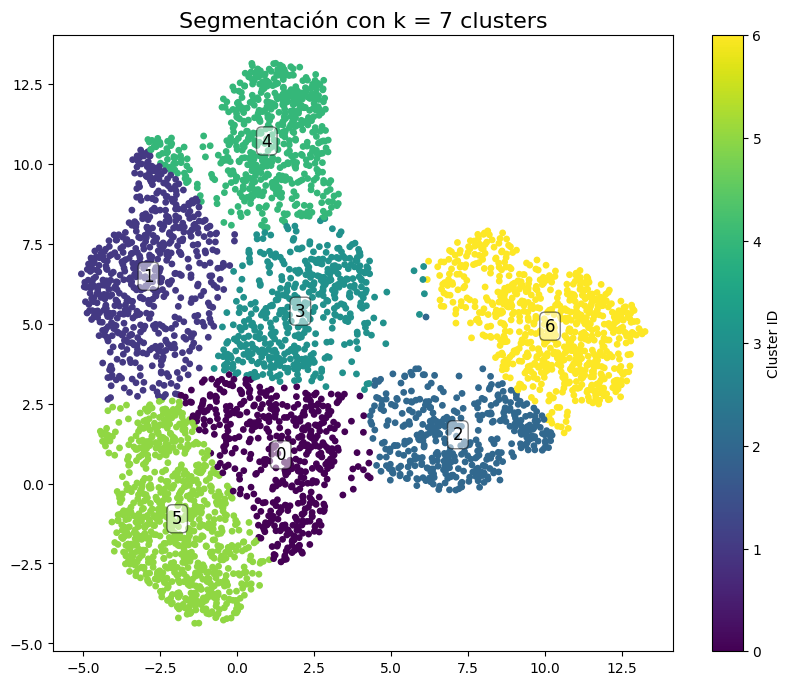

Number of cases per class and average churn probability per cluster:
original_class    0    1  average_prob_baja
cluster                                    
0                76  412           0.735776
1               265  360           0.523121
2               345   53           0.325108
3               151  315           0.557544
4               427  153           0.335288
5                50  752           0.827088
6               686   40           0.205386
--- Calculando clusters para k = 8 ---


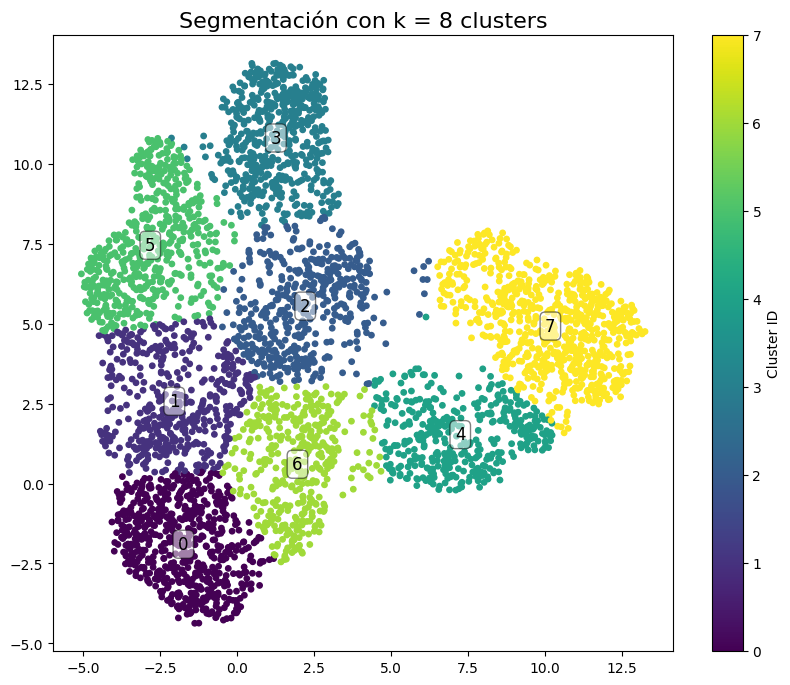

Number of cases per class and average churn probability per cluster:
original_class    0    1  average_prob_baja
cluster                                    
0                44  570           0.837019
1                48  405           0.726992
2               147  293           0.549114
3               389  134           0.332164
4               343   48           0.319601
5               282  258           0.471555
6                63  339           0.736691
7               684   38           0.204677
--- Calculando clusters para k = 9 ---


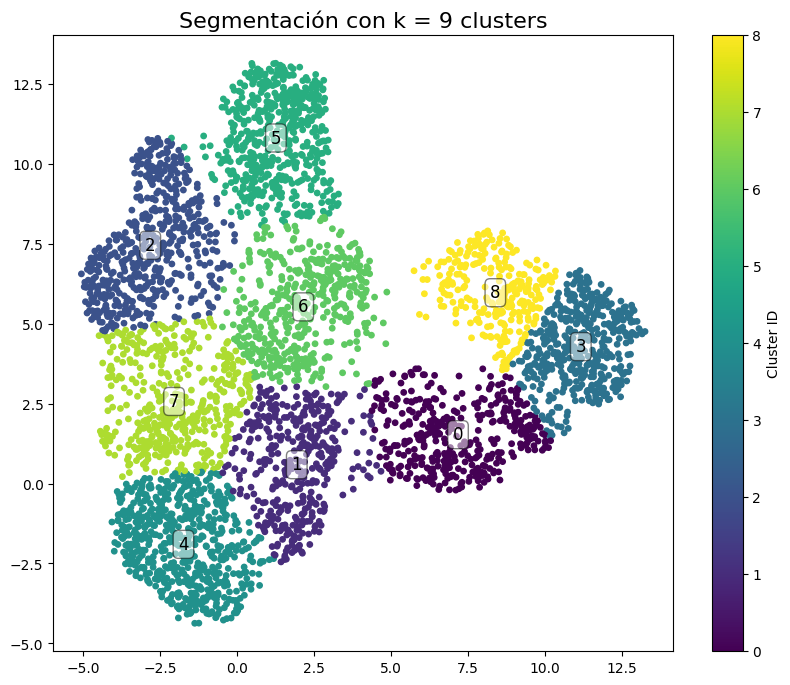

Number of cases per class and average churn probability per cluster:
original_class    0    1  average_prob_baja
cluster                                    
0               340   47           0.322954
1                60  338           0.738434
2               282  258           0.471555
3               446   17           0.168692
4                44  569           0.836991
5               389  134           0.332164
6               146  289           0.550522
7                48  405           0.727553
8               245   28           0.273407
--- Calculando clusters para k = 10 ---


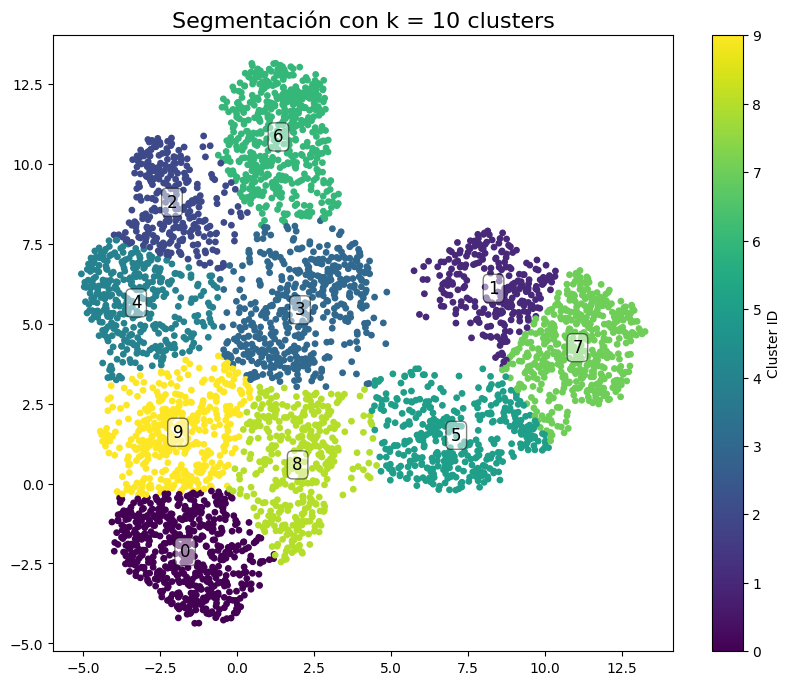

Number of cases per class and average churn probability per cluster:
original_class    0    1  average_prob_baja
cluster                                    
0                40  507           0.839445
1               226   27           0.277451
2               218   72           0.400627
3               147  307           0.555671
4                93  279           0.572448
5               332   48           0.325918
6               377  129           0.329902
7               473   18           0.171476
8                59  330           0.738942
9                35  368           0.766548


In [30]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

# --- TU ACCIÓN: Define aquí los valores de k que quieres probar ---
valores_k_a_probar = [5,6,7,8,9,10]

# Iteramos sobre cada valor de k
for k in valores_k_a_probar:
    print(f"--- Calculando clusters para k = {k} ---")
    
    # 1. Configurar y entrenar KMeans
    kmeans = KMeans(n_clusters=k, random_state=17, n_init=10)
    clusters = kmeans.fit_predict(embedding_rf)

    # 2. Visualizar el resultado
    plt.figure(figsize=(10, 8))
    plt.scatter(embedding_rf[:, 0], embedding_rf[:, 1], c=clusters, cmap='viridis', s=15)
    plt.colorbar(label='Cluster ID')
    plt.title(f'Segmentación con k = {k} clusters', fontsize=16)

    # 3. Añadir etiquetas de centroides (como en tu código original)
    for cluster_label in sorted(np.unique(clusters)):
        cluster_points = embedding_rf[clusters == cluster_label]
        centroid = cluster_points.mean(axis=0)
        plt.text(centroid[0], centroid[1], str(cluster_label), fontsize=12, 
                 ha='center', va='center', color='black',
                 bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.5))

    plt.show()

    cluster_class_df = pd.DataFrame({'cluster': clusters, 'original_class': ytrain_rf})
    class_distribution_by_cluster = cluster_class_df.groupby('cluster')['original_class'].value_counts().unstack(fill_value=0)
    cluster_prob_df = pd.DataFrame({'cluster': clusters, 'prob_baja': prob_baja.flatten()})
    average_prob_baja_by_cluster = cluster_prob_df.groupby('cluster')['prob_baja'].mean()
    class_distribution_by_cluster['average_prob_baja'] = average_prob_baja_by_cluster
    
    print("Number of cases per class and average churn probability per cluster:")
    print(class_distribution_by_cluster)

Veamos cuales de los clientes de cada cluster son **bajas** y cuales **continuan** y la proba promedio del cluster

In [31]:
cluster_class_df = pd.DataFrame({'cluster': clusters, 'original_class': ytrain_rf})

class_distribution_by_cluster = cluster_class_df.groupby('cluster')['original_class'].value_counts().unstack(fill_value=0)
cluster_prob_df = pd.DataFrame({'cluster': clusters, 'prob_baja': prob_baja.flatten()})
average_prob_baja_by_cluster = cluster_prob_df.groupby('cluster')['prob_baja'].mean()
class_distribution_by_cluster['average_prob_baja'] = average_prob_baja_by_cluster

print("Number of cases per class and average churn probability per cluster:")
print(class_distribution_by_cluster)

Number of cases per class and average churn probability per cluster:
original_class    0    1  average_prob_baja
cluster                                    
0                40  507           0.839445
1               226   27           0.277451
2               218   72           0.400627
3               147  307           0.555671
4                93  279           0.572448
5               332   48           0.325918
6               377  129           0.329902
7               473   18           0.171476
8                59  330           0.738942
9                35  368           0.766548


Por último necesitamos alguna forma de saber que hace a cada cluster distinto del otro. Para esto utilizaremos modelos (**rf**) que buscan separar los cluster uno a uno del resto de los datos.

Por cada modelo, miraremos cuales son las variables más importantes que separan los datos para luego caracterizarlos:

Manos a la obra:

Y exploramos las diferencias entre los clusters usando las **n** variables más importantes, usando en este caso la mediana


In [32]:
# sacar las features más importantes
importances = model.feature_importances_
feature_names = Xtrain_rf.columns
feature_importance_series = pd.Series(importances, index=feature_names)

feature_selected = feature_importance_series.sort_values(ascending=False)

n_top = 50 # cantidad de variables a evaluar.
top_overall_features = feature_selected.head(n_top).index.tolist()

cluster_series_aligned = pd.Series(clusters, index=Xtrain_rf.index)

cluster_median_values = {}

for cluster in sorted(np.unique(clusters)):
    cluster_indices = cluster_series_aligned[cluster_series_aligned == cluster].index
    cluster_data = Xtrain_rf.loc[cluster_indices, top_overall_features]

    # Usar el estadístico de su preferencia
    values = cluster_data.median()
    cluster_median_values[f'Cluster {cluster}'] = values

top_overall_features_df = pd.DataFrame(cluster_median_values)
display(top_overall_features_df)

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9
Visa_msaldototal,0.000000,25090.720000,36520.135000,1199.180000,19723.385000,1891.610000,26903.150000,27877.580000,0.000000,869.810000
Visa_msaldototal_lag1,0.000000,25379.000000,34870.500000,1385.725000,17519.040000,1770.550000,26594.850000,26286.130000,0.000000,862.635000
mautoservicio,0.000000,694.410000,0.000000,3198.625000,0.000000,17185.405000,14674.225000,22708.230000,0.000000,0.000000
Visa_msaldopesos_lag1,0.000000,29271.280000,40143.365000,1547.910000,20549.830000,2076.850000,31242.260000,30721.130000,0.000000,992.120000
mpasivos_margen_lag1,1.580000,525.320000,671.830000,370.840000,177.025000,522.190000,920.800000,1158.490000,16.730000,27.400000
mpasivos_margen,1.010000,486.240000,684.135000,263.870000,175.465000,448.455000,882.210000,1084.090000,10.130000,19.510000
mtarjeta_visa_consumo,0.000000,25630.550000,33295.345000,209.960000,15863.955000,1153.250000,27805.175000,31082.370000,0.000000,140.760000
mtarjeta_visa_consumo_rank,8.000000,60.000000,69.000000,16.000000,46.000000,18.000000,63.000000,67.000000,8.000000,16.000000
Visa_msaldopesos_rank,96.000000,56.000000,67.000000,15.000000,48.000000,17.000000,58.000000,59.000000,16.000000,12.000000
mautoservicio_rank,14.000000,32.000000,17.000000,39.000000,14.000000,64.000000,60.500000,71.000000,15.000000,16.000000


In [33]:
cluster_data

,Visa_msaldototal,Visa_msaldototal_lag1,mautoservicio,Visa_msaldopesos_lag1,mpasivos_margen_lag1,mpasivos_margen,mtarjeta_visa_consumo,mtarjeta_visa_consumo_rank,Visa_msaldopesos_rank,mautoservicio_rank,...,proporcion_comisiones_rentabilidad,mcuentas_saldo_lag1,mpayroll,mcuenta_corriente_lag2,targetcluster,Visa_mpagominimo_lag3,deuda_total_tc,mcuenta_corriente_delta3,mpayroll_rank,mautoservicio_lag1
10069,18107.36,NaN,0.0,NaN,4.01,3.39,0.00,12,46,7,...,0.556247,-21990.95,0.0,-16815.86,1,NaN,18107.36,-9322.38,20,0.0
10310,36758.06,NaN,0.0,NaN,39.39,32.35,0.00,14,68,14,...,0.249347,-28566.66,0.0,-24697.86,1,NaN,36758.06,-11838.52,38,0.0
18384,37309.81,NaN,0.0,NaN,8.28,7.45,0.00,4,68,13,...,0.205099,-38991.00,0.0,-31239.96,1,NaN,37309.81,-15082.96,24,0.0
19097,44549.38,NaN,0.0,NaN,27.50,25.82,0.00,4,73,8,...,0.245634,-5699.58,0.0,-3520.33,1,NaN,54978.89,1950.24,5,0.0
19836,81970.02,NaN,0.0,NaN,25.20,20.14,0.00,14,86,6,...,-0.000000,-62825.15,0.0,-50197.29,1,NaN,138701.22,-17559.10,20,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245794,9259.87,-15.92,0.0,-18.67,0.44,771.26,10751.48,36,29,11,...,3.259620,-4839.41,0.0,-1018.60,1,0.00,9259.87,-4467.60,46,0.0
246297,1029.87,-6.21,0.0,-7.28,16.24,15.50,0.00,6,13,9,...,0.823386,-1392.22,0.0,-1793.37,1,1231.65,1029.87,-534.38,32,0.0
248909,6301.06,6723.59,0.0,7886.77,89.97,70.68,4347.25,23,23,10,...,1.145710,-4432.64,0.0,-4487.80,1,1395.87,19356.52,-6930.35,6,0.0
250072,5641.33,3195.83,0.0,3748.70,52.30,48.47,5512.47,26,22,27,...,0.934017,-1647.12,0.0,-2520.08,1,1700.85,5641.33,-147.97,32,0.0


Otra de forma de explorar es graficar uno contra todos

In [34]:
def compare_cluster_stats(data, clusters, variable_name, target_cluster):

    cluster_series_aligned = pd.Series(clusters, index=data.index)

    variable_data = data[variable_name]

    target_cluster_indices = cluster_series_aligned[cluster_series_aligned == target_cluster].index
    target_cluster_data = variable_data.loc[target_cluster_indices] # Keep NaNs for counting

    rest_indices = cluster_series_aligned[cluster_series_aligned != target_cluster].index
    rest_data = variable_data.loc[rest_indices] # Keep NaNs for counting

    target_cluster_desc = target_cluster_data.dropna().describe()
    rest_desc = rest_data.dropna().describe()

    summary_df = pd.DataFrame({
        f'Cluster {target_cluster}': target_cluster_desc,
        f'Rest of Clusters': rest_desc
    })

    summary_df.loc['unique'] = [target_cluster_data.nunique(), rest_data.nunique()]
    summary_df.loc['missing'] = [target_cluster_data.isnull().sum(), rest_data.isnull().sum()]

    return summary_df

print(f"'mcaja_ahorro' - Cluster 0 vs. Rest")
compare_cluster_stats(Xtrain_rf, clusters, 'mcaja_ahorro', 0)

'mcaja_ahorro' - Cluster 0 vs. Rest


,Cluster 0,Rest of Clusters
count,547.000000,3.538000e+03
mean,133.913346,5.057649e+04
std,600.313497,1.555612e+05
min,0.000000,0.000000e+00
25%,0.000000,4.585550e+02
50%,0.000000,8.487625e+03
75%,0.000000,3.858960e+04
max,8567.290000,3.414134e+06
unique,96.000000,2.975000e+03
missing,0.000000,0.000000e+00


Muy interesante... pero no hay una brújula que nos ayude a ver que variables comparar?

Acá un salvavidas: Crea un modelo que busca separar los clusters del resto de los datos y nos devuelven las variables más importantes de esa separación

In [35]:
important_features_by_cluster = {}

for cluster in sorted(np.unique(clusters)):
    print(f"Training model for Cluster {cluster} vs. Rest...")
    y_binary = (cluster_series_aligned == cluster).astype(int)

    model = RandomForestClassifier(n_estimators=100, random_state=17, class_weight='balanced') # Added class_weight for imbalanced data
    model.fit(Xtrain_rf_imp, y_binary)

    importances = model.feature_importances_
    feature_names = Xtrain_rf.columns

    indices = np.argsort(importances)[::-1]

    important_features_by_cluster[cluster] = [feature_names[i] for i in indices]


Training model for Cluster 0 vs. Rest...
Training model for Cluster 1 vs. Rest...
Training model for Cluster 2 vs. Rest...
Training model for Cluster 3 vs. Rest...
Training model for Cluster 4 vs. Rest...
Training model for Cluster 5 vs. Rest...
Training model for Cluster 6 vs. Rest...
Training model for Cluster 7 vs. Rest...
Training model for Cluster 8 vs. Rest...
Training model for Cluster 9 vs. Rest...


Vemos las más importantes para un cluster

In [36]:
# Imprime los primeros 10 elementos de la lista de features para el Cluster 0
print(important_features_by_cluster[0][:10])

['Visa_mconsumototal_rank', 'ctarjeta_visa_transacciones', 'mtarjeta_visa_consumo', 'Visa_mpagosdolares_rank', 'Visa_mconsumospesos_rank', 'Visa_mpagospesos_rank', 'mtarjeta_visa_consumo_lag1', 'mcomisiones_mantenimiento_rank', 'mcaja_ahorro_lag2', 'mcuenta_corriente']


In [37]:
# Imprime los primeros 10 elementos de la lista de features para el Cluster 0
print(important_features_by_cluster[9][:10])

['Visa_msaldototal', 'mpasivos_margen_lag1', 'mtarjeta_visa_consumo', 'Visa_msaldototal_rank', 'mcomisiones_mantenimiento_delta3', 'Visa_msaldopesos', 'Visa_msaldopesos_rank', 'mpasivos_margen_lag2', 'Visa_msaldopesos_lag1', 'mautoservicio']


In [38]:
# Imprime los primeros 10 elementos de la lista de features para el Cluster 0
print(important_features_by_cluster[8][:10])

['mcomisiones_rank', 'mcomisiones_otras', 'mcomisiones', 'mcomisiones_otras_rank', 'mcomisiones_delta2', 'consumo_total_tc', 'mcomisiones_mantenimiento_rank', 'mtarjeta_visa_consumo', 'mcomisiones_lag1', 'mcomisiones_otras_delta2']


In [39]:
# Imprime los primeros 10 elementos de la lista de features para el Cluster 0
print(important_features_by_cluster[4][:10])

['mautoservicio', 'monto_promedio_trx_debito', 'mautoservicio_rank', 'deuda_total_tc', 'consumo_total_tc', 'mautoservicio_lag1', 'mautoservicio_lag2', 'ctarjeta_debito_transacciones', 'mtarjeta_visa_consumo_rank', 'mcaja_ahorro_lag2']


In [40]:
# Imprime los primeros 10 elementos de la lista de features para el Cluster 0
print(important_features_by_cluster[3][:10])

['Visa_msaldototal_lag1', 'mpayroll_rank', 'mcaja_ahorro_rank', 'mpayroll', 'Visa_msaldototal', 'mtarjeta_visa_consumo', 'cpayroll_trx', 'Visa_msaldopesos_lag1', 'mpasivos_margen_lag2', 'mcaja_ahorro']


In [41]:
# Imprime los primeros 10 elementos de la lista de features para el Cluster 0
print(important_features_by_cluster[7][:10])

['mpayroll_rank', 'ratio_saldo_cuenta_ingreso', 'mpayroll_lag1', 'ratio_deuda_total_ingreso', 'mpayroll_lag2', 'mpayroll', 'mautoservicio', 'cpayroll_trx', 'monto_promedio_trx_debito', 'mautoservicio_rank']


Y luego miramos los estadísticos

In [44]:
import pandas as pd
import numpy as np

# --- Requisitos Previos ---
# Este código asume que ya tienes las siguientes variables cargadas en tu entorno:
# 1. Xtrain_rf: El DataFrame con los datos de los clientes utilizados en el clustering.
# 2. clusters: El array de NumPy con la etiqueta del cluster para cada cliente en Xtrain_rf.

# -------------------------------------------------------------------
# Paso 1: Definición de la Función de Comparación
# -------------------------------------------------------------------
# Esta es la misma función que tenías en tu notebook para comparar un cluster contra el resto.
def compare_cluster_stats(data, clusters, variable_name, target_cluster):
    # Asegurarse de que los índices estén alineados
    cluster_series_aligned = pd.Series(clusters, index=data.index)
    
    variable_data = data[variable_name]
    
    # Datos del cluster objetivo
    target_cluster_indices = cluster_series_aligned[cluster_series_aligned == target_cluster].index
    target_cluster_data = variable_data.loc[target_cluster_indices]
    
    # Datos del resto de los clusters
    rest_indices = cluster_series_aligned[cluster_series_aligned != target_cluster].index
    rest_data = variable_data.loc[rest_indices]
    
    # Calcular estadísticas descriptivas
    target_cluster_desc = target_cluster_data.dropna().describe()
    rest_desc = rest_data.dropna().describe()
    
    # Crear DataFrame de resumen
    summary_df = pd.DataFrame({
        f'Cluster {target_cluster}': target_cluster_desc,
        f'Resto de Clusters': rest_desc
    })
    
    # Añadir conteos de valores únicos y faltantes
    summary_df.loc['unique'] = [target_cluster_data.nunique(), rest_data.nunique()]
    summary_df.loc['missing'] = [target_cluster_data.isnull().sum(), rest_data.isnull().sum()]
    
    return summary_df

# -------------------------------------------------------------------
# Paso 2: Almacenar las Variables Importantes de Cada Cluster
# -------------------------------------------------------------------
# Guardamos en un diccionario las 10 variables más importantes que identificaste para cada cluster.
important_features_by_cluster = {
    0: ['Visa_mconsumototal_rank', 'ctarjeta_visa_transacciones', 'mtarjeta_visa_consumo', 'Visa_mpagosdolares_rank', 'Visa_mconsumospesos_rank', 'Visa_mpagospesos_rank', 'mtarjeta_visa_consumo_lag1', 'mcomisiones_mantenimiento_rank', 'mcaja_ahorro_lag2', 'mcuenta_corriente'],
    9: ['Visa_msaldototal', 'mpasivos_margen_lag1', 'mtarjeta_visa_consumo', 'Visa_msaldototal_rank', 'mcomisiones_mantenimiento_delta3', 'Visa_msaldopesos', 'Visa_msaldopesos_rank', 'mpasivos_margen_lag2', 'Visa_msaldopesos_lag1', 'mautoservicio'],
    8: ['mcomisiones_rank', 'mcomisiones_otras', 'mcomisiones', 'mcomisiones_otras_rank', 'mcomisiones_delta2', 'consumo_total_tc', 'mcomisiones_mantenimiento_rank', 'mtarjeta_visa_consumo', 'mcomisiones_lag1', 'mcomisiones_otras_delta2'],
    4: ['mautoservicio', 'monto_promedio_trx_debito', 'mautoservicio_rank', 'deuda_total_tc', 'consumo_total_tc', 'mautoservicio_lag1', 'mautoservicio_lag2', 'ctarjeta_debito_transacciones', 'mtarjeta_visa_consumo_rank', 'mcaja_ahorro_lag2'],
    3: ['Visa_msaldototal_lag1', 'mpayroll_rank', 'mcaja_ahorro_rank', 'mpayroll', 'Visa_msaldototal', 'mtarjeta_visa_consumo', 'cpayroll_trx', 'Visa_msaldopesos_lag1', 'mpasivos_margen_lag2', 'mcaja_ahorro'],
}

# -------------------------------------------------------------------
# Paso 3: Iterar y Mostrar las Comparaciones
# -------------------------------------------------------------------
# Este bucle recorrerá cada cluster y sus 10 variables, imprimiendo la tabla de comparación.
for cluster_id, features in important_features_by_cluster.items():
    print(f"==============================================================")
    print(f" ANÁLISIS ESTADÍSTICO PARA EL CLUSTER {cluster_id}")
    print(f"==============================================================\n")
    
    for variable in features:
        print(f"### Comparación para la variable: '{variable}' ###")
        
        # Llamar a la función y mostrar el resultado
        stats_df = compare_cluster_stats(Xtrain_rf, clusters, variable, cluster_id)
        display(stats_df) # 'display' funciona mejor que 'print' para DataFrames en notebooks
        print("\n" + "-"*60 + "\n")

 ANÁLISIS ESTADÍSTICO PARA EL CLUSTER 0

### Comparación para la variable: 'Visa_mconsumototal_rank' ###


,Cluster 0,Resto de Clusters
count,547.000000,3538.000000
mean,93.528336,49.667891
std,6.813087,31.877153
min,9.000000,1.000000
25%,91.000000,20.000000
50%,94.000000,47.000000
75%,97.000000,80.000000
max,100.000000,100.000000
unique,17.000000,100.000000
missing,0.000000,0.000000



------------------------------------------------------------

### Comparación para la variable: 'ctarjeta_visa_transacciones' ###


,Cluster 0,Resto de Clusters
count,547.0,3538.000000
mean,0.0,9.172696
std,0.0,13.074453
min,0.0,0.000000
25%,0.0,0.000000
50%,0.0,5.000000
75%,0.0,13.000000
max,0.0,163.000000
unique,1.0,85.000000
missing,0.0,0.000000



------------------------------------------------------------

### Comparación para la variable: 'mtarjeta_visa_consumo' ###


,Cluster 0,Resto de Clusters
count,547.0,3538.000000
mean,0.0,22163.090670
std,0.0,37510.992146
min,0.0,0.000000
25%,0.0,0.000000
50%,0.0,9830.830000
75%,0.0,28834.145000
max,0.0,871214.780000
unique,1.0,2545.000000
missing,0.0,0.000000



------------------------------------------------------------

### Comparación para la variable: 'Visa_mpagosdolares_rank' ###


,Cluster 0,Resto de Clusters
count,547.000000,3538.000000
mean,93.904936,55.161391
std,5.978756,29.758698
min,10.000000,1.000000
25%,91.000000,30.000000
50%,95.000000,57.000000
75%,97.000000,81.000000
max,100.000000,100.000000
unique,17.000000,100.000000
missing,0.000000,0.000000



------------------------------------------------------------

### Comparación para la variable: 'Visa_mconsumospesos_rank' ###


,Cluster 0,Resto de Clusters
count,547.000000,3538.000000
mean,93.369287,49.733183
std,6.741350,31.971477
min,9.000000,1.000000
25%,91.000000,20.000000
50%,93.000000,47.000000
75%,96.000000,80.000000
max,100.000000,100.000000
unique,17.000000,100.000000
missing,0.000000,0.000000



------------------------------------------------------------

### Comparación para la variable: 'Visa_mpagospesos_rank' ###


,Cluster 0,Resto de Clusters
count,547.000000,3538.000000
mean,93.308958,59.788581
std,3.924840,28.838969
min,72.000000,1.000000
25%,91.000000,36.000000
50%,93.000000,66.000000
75%,96.500000,85.000000
max,100.000000,100.000000
unique,16.000000,100.000000
missing,0.000000,0.000000



------------------------------------------------------------

### Comparación para la variable: 'mtarjeta_visa_consumo_lag1' ###


,Cluster 0,Resto de Clusters
count,547.000000,3.513000e+03
mean,74.249598,2.209016e+04
std,929.478657,4.145009e+04
min,0.000000,0.000000e+00
25%,0.000000,1.856200e+02
50%,0.000000,9.867150e+03
75%,0.000000,2.789980e+04
max,19295.340000,1.270025e+06
unique,7.000000,2.633000e+03
missing,0.000000,2.500000e+01



------------------------------------------------------------

### Comparación para la variable: 'mcomisiones_mantenimiento_rank' ###


,Cluster 0,Resto de Clusters
count,547.000000,3538.000000
mean,83.802559,55.156586
std,10.445803,29.963606
min,3.000000,1.000000
25%,79.000000,28.000000
50%,83.000000,60.000000
75%,91.000000,82.000000
max,100.000000,100.000000
unique,40.000000,100.000000
missing,0.000000,0.000000



------------------------------------------------------------

### Comparación para la variable: 'mcaja_ahorro_lag2' ###


,Cluster 0,Resto de Clusters
count,547.000000,3.475000e+03
mean,296.676197,5.134364e+04
std,1221.914226,1.494378e+05
min,0.000000,-5.264700e+02
25%,0.000000,7.525200e+02
50%,0.000000,1.037516e+04
75%,0.000000,4.355688e+04
max,14158.790000,2.843199e+06
unique,131.000000,2.996000e+03
missing,0.000000,6.300000e+01



------------------------------------------------------------

### Comparación para la variable: 'mcuenta_corriente' ###


,Cluster 0,Resto de Clusters
count,5.470000e+02,3538.000000
mean,-2.524216e+04,-1640.334503
std,8.682466e+04,33700.397432
min,-1.358991e+06,-789208.600000
25%,-2.283687e+04,-1749.057500
50%,-1.082662e+04,-28.750000
75%,-3.338745e+03,0.000000
max,0.000000e+00,865682.280000
unique,5.450000e+02,2090.000000
missing,0.000000e+00,0.000000



------------------------------------------------------------

 ANÁLISIS ESTADÍSTICO PARA EL CLUSTER 9

### Comparación para la variable: 'Visa_msaldototal' ###


,Cluster 9,Resto de Clusters
count,3.980000e+02,3.098000e+03
mean,1.441189e+04,2.707753e+04
std,9.677046e+04,5.436038e+04
min,-4.323210e+03,-1.148276e+05
25%,0.000000e+00,1.215358e+03
50%,8.698100e+02,1.304147e+04
75%,2.940037e+03,3.310056e+04
max,1.147339e+06,1.326793e+06
unique,2.950000e+02,2.485000e+03
missing,5.000000e+00,5.840000e+02



------------------------------------------------------------

### Comparación para la variable: 'mpasivos_margen_lag1' ###


,Cluster 9,Resto de Clusters
count,403.000000,3657.000000
mean,48.586501,1094.364990
std,263.341218,3223.669921
min,-3305.100000,-5631.240000
25%,6.235000,43.340000
50%,27.400000,330.580000
75%,66.390000,1042.600000
max,2786.500000,94008.550000
unique,385.000000,3319.000000
missing,0.000000,25.000000



------------------------------------------------------------

### Comparación para la variable: 'mtarjeta_visa_consumo' ###


,Cluster 9,Resto de Clusters
count,403.000000,3682.000000
mean,1348.531737,21148.711706
std,2085.210658,37095.644883
min,0.000000,0.000000
25%,0.000000,0.000000
50%,140.760000,8738.370000
75%,1841.560000,27761.777500
max,10751.480000,871214.780000
unique,196.000000,2357.000000
missing,0.000000,0.000000



------------------------------------------------------------

### Comparación para la variable: 'Visa_msaldototal_rank' ###


,Cluster 9,Resto de Clusters
count,403.000000,3682.000000
mean,16.856079,49.432917
std,19.462661,33.587013
min,1.000000,1.000000
25%,9.000000,17.000000
50%,13.000000,46.000000
75%,17.000000,82.000000
max,100.000000,100.000000
unique,48.000000,100.000000
missing,0.000000,0.000000



------------------------------------------------------------

### Comparación para la variable: 'mcomisiones_mantenimiento_delta3' ###


,Cluster 9,Resto de Clusters
count,403.000000,3682.000000
mean,1058.444913,349.416695
std,1117.568823,1079.161305
min,-6347.280000,-7878.460000
25%,409.100000,0.000000
50%,577.780000,0.000000
75%,1774.040000,409.100000
max,7220.490000,6362.300000
unique,29.000000,107.000000
missing,0.000000,0.000000



------------------------------------------------------------

### Comparación para la variable: 'Visa_msaldopesos' ###


,Cluster 9,Resto de Clusters
count,3.980000e+02,3.098000e+03
mean,1.689847e+04,3.146957e+04
std,1.135122e+05,6.287395e+04
min,-5.071120e+03,-1.346927e+05
25%,0.000000e+00,1.499130e+03
50%,1.020280e+03,1.522819e+04
75%,3.448655e+03,3.825714e+04
max,1.345829e+06,1.547678e+06
unique,2.930000e+02,2.479000e+03
missing,5.000000e+00,5.840000e+02



------------------------------------------------------------

### Comparación para la variable: 'Visa_msaldopesos_rank' ###


,Cluster 9,Resto de Clusters
count,403.000000,3682.000000
mean,16.568238,49.361217
std,19.579718,33.565781
min,1.000000,1.000000
25%,7.000000,17.000000
50%,12.000000,46.500000
75%,16.500000,82.000000
max,100.000000,100.000000
unique,48.000000,100.000000
missing,0.000000,0.000000



------------------------------------------------------------

### Comparación para la variable: 'mpasivos_margen_lag2' ###


,Cluster 9,Resto de Clusters
count,403.000000,3619.000000
mean,57.133275,944.013432
std,267.444056,2462.256022
min,-3087.620000,-4664.020000
25%,3.915000,37.145000
50%,26.570000,281.360000
75%,73.865000,930.715000
max,1656.710000,63455.800000
unique,382.000000,3286.000000
missing,0.000000,63.000000



------------------------------------------------------------

### Comparación para la variable: 'Visa_msaldopesos_lag1' ###


,Cluster 9,Resto de Clusters
count,374.000000,3.132000e+03
mean,3210.666631,3.244198e+04
std,10073.149570,6.851926e+04
min,-2713.030000,-1.346927e+05
25%,0.000000,1.384842e+03
50%,992.120000,1.473032e+04
75%,3735.720000,3.771420e+04
max,176440.710000,1.493061e+06
unique,276.000000,2.536000e+03
missing,29.000000,5.500000e+02



------------------------------------------------------------

### Comparación para la variable: 'mautoservicio' ###


,Cluster 9,Resto de Clusters
count,403.000000,3682.000000
mean,19.837469,12611.770744
std,121.368302,26265.925955
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,277.165000
75%,0.000000,16161.740000
max,1196.460000,546044.770000
unique,12.000000,1798.000000
missing,0.000000,0.000000



------------------------------------------------------------

 ANÁLISIS ESTADÍSTICO PARA EL CLUSTER 8

### Comparación para la variable: 'mcomisiones_rank' ###


,Cluster 8,Resto de Clusters
count,389.000000,3696.000000
mean,11.007712,55.683171
std,15.199615,28.029522
min,1.000000,1.000000
25%,4.000000,31.000000
50%,5.000000,65.000000
75%,10.000000,79.000000
max,91.000000,100.000000
unique,51.000000,100.000000
missing,0.000000,0.000000



------------------------------------------------------------

### Comparación para la variable: 'mcomisiones_otras' ###


,Cluster 8,Resto de Clusters
count,389.000000,3696.000000
mean,89.086915,1510.622132
std,521.860429,1632.131272
min,-2391.370000,-5466.620000
25%,0.000000,441.562500
50%,0.000000,1592.200000
75%,83.960000,2209.200000
max,3243.090000,30137.200000
unique,147.000000,3019.000000
missing,0.000000,0.000000



------------------------------------------------------------

### Comparación para la variable: 'mcomisiones' ###


,Cluster 8,Resto de Clusters
count,389.000000,3696.000000
mean,88.722005,1505.804245
std,521.883855,1628.233084
min,-2391.370000,-5466.620000
25%,0.000000,439.720000
50%,0.000000,1592.200000
75%,83.960000,2202.835000
max,3243.090000,30137.200000
unique,144.000000,3011.000000
missing,0.000000,0.000000



------------------------------------------------------------

### Comparación para la variable: 'mcomisiones_otras_rank' ###


,Cluster 8,Resto de Clusters
count,389.000000,3696.000000
mean,11.059126,55.631764
std,15.153309,28.033152
min,1.000000,1.000000
25%,4.000000,31.000000
50%,5.000000,65.000000
75%,10.000000,79.000000
max,91.000000,100.000000
unique,52.000000,100.000000
missing,0.000000,0.000000



------------------------------------------------------------

### Comparación para la variable: 'mcomisiones_delta2' ###


,Cluster 8,Resto de Clusters
count,389.000000,3696.000000
mean,-160.251260,448.888263
std,727.386972,1347.516866
min,-4157.810000,-12142.870000
25%,-11.870000,0.000000
50%,0.000000,367.160000
75%,0.000000,740.355000
max,3675.120000,21991.070000
unique,186.000000,3085.000000
missing,0.000000,0.000000



------------------------------------------------------------

### Comparación para la variable: 'consumo_total_tc' ###


,Cluster 8,Resto de Clusters
count,389.000000,3.696000e+03
mean,630.338329,2.640895e+04
std,1893.925971,5.353561e+04
min,0.000000,0.000000e+00
25%,0.000000,0.000000e+00
50%,0.000000,1.022425e+04
75%,0.000000,3.293651e+04
max,15836.140000,1.169737e+06
unique,70.000000,2.540000e+03
missing,0.000000,0.000000e+00



------------------------------------------------------------

### Comparación para la variable: 'mcomisiones_mantenimiento_rank' ###


,Cluster 8,Resto de Clusters
count,389.000000,3696.000000
mean,34.097686,61.612554
std,22.242008,29.269478
min,1.000000,1.000000
25%,17.000000,38.000000
50%,30.000000,73.000000
75%,52.000000,85.000000
max,97.000000,100.000000
unique,75.000000,100.000000
missing,0.000000,0.000000



------------------------------------------------------------

### Comparación para la variable: 'mtarjeta_visa_consumo' ###


,Cluster 8,Resto de Clusters
count,389.000000,3696.000000
mean,461.460308,21167.074332
std,1286.622770,36998.327844
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,8704.965000
75%,0.000000,27632.382500
max,6664.380000,871214.780000
unique,62.000000,2486.000000
missing,0.000000,0.000000



------------------------------------------------------------

### Comparación para la variable: 'mcomisiones_lag1' ###


,Cluster 8,Resto de Clusters
count,385.000000,3675.000000
mean,424.733870,1770.140117
std,1475.747704,3158.760543
min,-5191.610000,-3907.350000
25%,0.000000,373.015000
50%,1.700000,1592.200000
75%,181.190000,2241.590000
max,12272.660000,121743.600000
unique,173.000000,3039.000000
missing,4.000000,21.000000



------------------------------------------------------------

### Comparación para la variable: 'mcomisiones_otras_delta2' ###


,Cluster 8,Resto de Clusters
count,389.000000,3696.000000
mean,-160.484447,450.514573
std,727.358205,1347.378347
min,-4157.810000,-12142.870000
25%,-12.280000,0.000000
50%,0.000000,367.160000
75%,0.000000,741.700000
max,3675.120000,21991.070000
unique,188.000000,3090.000000
missing,0.000000,0.000000



------------------------------------------------------------

 ANÁLISIS ESTADÍSTICO PARA EL CLUSTER 4

### Comparación para la variable: 'mautoservicio' ###


,Cluster 4,Resto de Clusters
count,372.000000,3713.000000
mean,26.746210,12505.947964
std,135.543148,26181.433535
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,34.010000
75%,0.000000,15891.690000
max,1286.960000,546044.770000
unique,20.000000,1795.000000
missing,0.000000,0.000000



------------------------------------------------------------

### Comparación para la variable: 'monto_promedio_trx_debito' ###


,Cluster 4,Resto de Clusters
count,372.000000,3713.000000
mean,24.175766,1382.392298
std,124.566379,2967.852646
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,17.005000
75%,0.000000,1903.992667
max,1286.960000,82110.000000
unique,20.000000,1801.000000
missing,0.000000,0.000000



------------------------------------------------------------

### Comparación para la variable: 'mautoservicio_rank' ###


,Cluster 4,Resto de Clusters
count,372.000000,3713.000000
mean,15.701613,39.086992
std,9.074397,28.420710
min,1.000000,1.000000
25%,8.000000,15.000000
50%,14.000000,30.000000
75%,24.000000,62.000000
max,34.000000,100.000000
unique,34.000000,100.000000
missing,0.000000,0.000000



------------------------------------------------------------

### Comparación para la variable: 'deuda_total_tc' ###


,Cluster 4,Resto de Clusters
count,3.720000e+02,3.713000e+03
mean,4.940463e+04,2.841707e+04
std,2.494332e+05,1.040510e+05
min,-3.192917e+04,-1.148276e+05
25%,1.238262e+04,0.000000e+00
50%,2.307151e+04,5.019750e+03
75%,4.157936e+04,2.919017e+04
max,4.732161e+06,4.039095e+06
unique,3.720000e+02,2.488000e+03
missing,0.000000e+00,0.000000e+00



------------------------------------------------------------

### Comparación para la variable: 'consumo_total_tc' ###


,Cluster 4,Resto de Clusters
count,3.720000e+02,3.713000e+03
mean,2.729103e+04,2.361982e+04
std,6.275154e+04,5.021482e+04
min,0.000000e+00,0.000000e+00
25%,1.095470e+04,0.000000e+00
50%,1.837695e+04,4.590180e+03
75%,3.455544e+04,2.935100e+04
max,1.169737e+06,1.045197e+06
unique,3.480000e+02,2.261000e+03
missing,0.000000e+00,0.000000e+00



------------------------------------------------------------

### Comparación para la variable: 'mautoservicio_lag1' ###


,Cluster 4,Resto de Clusters
count,372.000000,3688.000000
mean,612.275914,13442.047486
std,4240.632952,26221.265356
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,694.410000
75%,0.000000,17621.820000
max,70379.240000,506276.640000
unique,39.000000,1867.000000
missing,0.000000,25.000000



------------------------------------------------------------

### Comparación para la variable: 'mautoservicio_lag2' ###


,Cluster 4,Resto de Clusters
count,369.000000,3653.000000
mean,504.060407,11376.264717
std,2576.043515,22798.665337
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,682.680000
75%,0.000000,14275.290000
max,31087.580000,403470.190000
unique,41.000000,1847.000000
missing,3.000000,60.000000



------------------------------------------------------------

### Comparación para la variable: 'ctarjeta_debito_transacciones' ###


,Cluster 4,Resto de Clusters
count,372.000000,3713.000000
mean,0.059140,5.478858
std,0.278129,9.839917
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,1.000000
75%,0.000000,7.000000
max,3.000000,107.000000
unique,4.000000,69.000000
missing,0.000000,0.000000



------------------------------------------------------------

### Comparación para la variable: 'mtarjeta_visa_consumo_rank' ###


,Cluster 4,Resto de Clusters
count,372.000000,3713.000000
mean,48.276882,34.519795
std,21.483930,29.671399
min,1.000000,1.000000
25%,34.000000,10.000000
50%,46.000000,22.000000
75%,64.250000,58.000000
max,100.000000,100.000000
unique,88.000000,100.000000
missing,0.000000,0.000000



------------------------------------------------------------

### Comparación para la variable: 'mcaja_ahorro_lag2' ###


,Cluster 4,Resto de Clusters
count,369.000000,3.653000e+03
mean,2817.253984,4.860166e+04
std,7124.669605,1.462298e+05
min,-28.260000,-5.264700e+02
25%,0.000000,6.283000e+01
50%,335.050000,8.417910e+03
75%,2423.260000,3.983146e+04
max,53119.900000,2.843199e+06
unique,258.000000,2.868000e+03
missing,3.000000,6.000000e+01



------------------------------------------------------------

 ANÁLISIS ESTADÍSTICO PARA EL CLUSTER 3

### Comparación para la variable: 'Visa_msaldototal_lag1' ###


,Cluster 3,Resto de Clusters
count,388.000000,3.118000e+03
mean,2311.374175,2.808615e+04
std,11860.520543,5.916003e+04
min,-114827.550000,-1.481841e+05
25%,0.000000,9.825975e+02
50%,1385.725000,1.268084e+04
75%,4588.507500,3.229629e+04
max,106674.520000,1.278901e+06
unique,270.000000,2.551000e+03
missing,66.000000,5.130000e+02



------------------------------------------------------------

### Comparación para la variable: 'mpayroll_rank' ###


,Cluster 3,Resto de Clusters
count,454.000000,3631.000000
mean,24.226872,39.985403
std,13.701938,26.857404
min,1.000000,1.000000
25%,13.000000,19.000000
50%,23.000000,35.000000
75%,35.000000,58.000000
max,67.000000,100.000000
unique,50.000000,100.000000
missing,0.000000,0.000000



------------------------------------------------------------

### Comparación para la variable: 'mcaja_ahorro_rank' ###


,Cluster 3,Resto de Clusters
count,454.000000,3631.000000
mean,44.643172,33.021206
std,26.387007,30.125309
min,1.000000,1.000000
25%,24.000000,7.000000
50%,38.000000,21.000000
75%,63.750000,57.000000
max,100.000000,100.000000
unique,97.000000,100.000000
missing,0.000000,0.000000



------------------------------------------------------------

### Comparación para la variable: 'mpayroll' ###


,Cluster 3,Resto de Clusters
count,454.000000,3.631000e+03
mean,468.309559,4.326916e+04
std,5785.817938,1.425819e+05
min,0.000000,0.000000e+00
25%,0.000000,0.000000e+00
50%,0.000000,0.000000e+00
75%,0.000000,6.217275e+04
max,83027.280000,5.990816e+06
unique,6.000000,1.139000e+03
missing,0.000000,0.000000e+00



------------------------------------------------------------

### Comparación para la variable: 'Visa_msaldototal' ###


,Cluster 3,Resto de Clusters
count,388.000000,3.108000e+03
mean,1837.968505,2.860649e+04
std,9057.226494,6.380079e+04
min,-114827.550000,-1.144135e+05
25%,0.000000,9.785125e+02
50%,1199.180000,1.326015e+04
75%,4456.505000,3.415506e+04
max,37210.720000,1.326793e+06
unique,252.000000,2.529000e+03
missing,66.000000,5.230000e+02



------------------------------------------------------------

### Comparación para la variable: 'mtarjeta_visa_consumo' ###


,Cluster 3,Resto de Clusters
count,454.000000,3631.000000
mean,2737.260859,21253.180490
std,5590.446368,37324.516152
min,0.000000,0.000000
25%,0.000000,0.000000
50%,209.960000,8701.590000
75%,4183.532500,28029.610000
max,78911.220000,871214.780000
unique,230.000000,2327.000000
missing,0.000000,0.000000



------------------------------------------------------------

### Comparación para la variable: 'cpayroll_trx' ###


,Cluster 3,Resto de Clusters
count,454.000000,3631.000000
mean,0.022026,0.574497
std,0.229115,1.352439
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,1.000000
max,3.000000,35.000000
unique,4.000000,16.000000
missing,0.000000,0.000000



------------------------------------------------------------

### Comparación para la variable: 'Visa_msaldopesos_lag1' ###


,Cluster 3,Resto de Clusters
count,388.000000,3.118000e+03
mean,2938.715335,3.260707e+04
std,12514.542694,6.857711e+04
min,-134692.710000,-8.281134e+04
25%,0.000000,1.148317e+03
50%,1547.910000,1.491755e+04
75%,5444.297500,3.774565e+04
max,125129.210000,1.493061e+06
unique,268.000000,2.545000e+03
missing,66.000000,5.130000e+02



------------------------------------------------------------

### Comparación para la variable: 'mpasivos_margen_lag2' ###


,Cluster 3,Resto de Clusters
count,443.000000,3579.000000
mean,1113.644966,823.153004
std,2542.365565,2326.041223
min,-2255.000000,-4664.020000
25%,143.865000,16.820000
50%,331.410000,194.050000
75%,1060.515000,816.975000
max,32657.990000,63455.800000
unique,442.000000,3184.000000
missing,11.000000,52.000000



------------------------------------------------------------

### Comparación para la variable: 'mcaja_ahorro' ###


,Cluster 3,Resto de Clusters
count,4.540000e+02,3.631000e+03
mean,6.194831e+04,4.155559e+04
std,2.088178e+05,1.357336e+05
min,0.000000e+00,0.000000e+00
25%,4.646475e+03,0.000000e+00
50%,1.249236e+04,3.380460e+03
75%,3.887612e+04,2.944149e+04
max,3.414134e+06,2.586169e+06
unique,4.410000e+02,2.628000e+03
missing,0.000000e+00,0.000000e+00



------------------------------------------------------------



In [42]:
compare_cluster_stats(Xtrain_rf, clusters, 'mpasivos_margen', 0)

,Cluster 0,Rest of Clusters
count,547.000000,3538.000000
mean,21.761627,1019.468092
std,134.455984,3155.457741
min,-2228.610000,-25859.240000
25%,0.000000,60.737500
50%,1.010000,333.475000
75%,19.685000,1027.795000
max,1135.140000,98067.860000
unique,320.000000,3361.000000
missing,0.000000,0.000000


Es perfecto? **NO** pero es orientativo

Luego resta, analizar los estadísticos de los datos de cada cluster para las variables importantes, comparar sus distribuciones con histogramas, boxplots, pivot tables, etc.


Junto con el diccionaro de datos, de sentido a lo que ve a través del análisis multivariado de datos.

Obviamente, esto es apenas mas que una semilla. Agregue las variables históricas, juegue con los **rf** y genere una segmentación pro, que encante a Miranda
